In [336]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
# from snowflake.connector.pandas_tools import write_pandas
# from sqlalchemy import create_engine

import json
from tqdm import tqdm
import os

from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

from datetime import datetime

In [337]:
pd.set_option('display.max_columns', None)

In [338]:
## Import snowflake connection
import snowflake.connector

In [581]:
## Set options to view all columns
pd.set_option('display.max_columns', None)

In [582]:
SNOWFLAKE_USER = 'karan14'
SNOWFLAKE_PASSWORD = 'Snowfl@key0014'
SNOWFLAKE_ACCOUNT = 'lv65293.ca-central-1.aws'
SNOWFLAKE_WAREHOUSE = 'COMPUTE_WH'
SNOWFLAKE_DATABASE = 'GEGENSTATS'
SNOWFLAKE_SCHEMA = 'TABLES'

In [583]:
conn = snowflake.connector.connect(
    user=SNOWFLAKE_USER,
    password=SNOWFLAKE_PASSWORD,
    account=SNOWFLAKE_ACCOUNT,
    warehouse=SNOWFLAKE_WAREHOUSE,
    database=SNOWFLAKE_DATABASE,
    schema=SNOWFLAKE_SCHEMA
)

In [584]:
cursor = conn.cursor()

In [445]:
def fetch_data(cursor, query, params=None):
    if params:
        cursor.execute(query, params)
    else:
        cursor.execute(query)
    rows = cursor.fetchall()
    column_names = [desc[0] for desc in cursor.description]
    return pd.DataFrame(rows, columns=column_names)

In [806]:
df_matches = fetch_data(cursor, 'SELECT * FROM MATCHES')

In [807]:
team_names = fetch_data(cursor, 'SELECT * FROM TEAMS')

In [808]:
team_names[team_names['TEAM_NAME'] == "Arsenal"]['TEAM_FBREF_ID'].iloc[0]

'18bb7c10'

In [809]:
df_competitions = fetch_data(cursor, 'SELECT COMPETITION, COMPETITION_ACRONYM, SEASON FROM COMPETITIONS')

In [810]:
df_last_matches = df_matches.merge(df_competitions, on=['COMPETITION', 'SEASON'])

In [811]:
df_last_matches['DATE_TIME'] = pd.to_datetime(df_last_matches['DATE_TIME'])

In [812]:
home_teams = team_names.copy()
away_teams = team_names.copy()

home_teams.rename({'TEAM_FBREF_ID':'HOME_TEAM_ID', 'TEAM_NAME':'HOME_TEAM_NAME'}, axis=1, inplace=True)
away_teams.rename({'TEAM_FBREF_ID':'AWAY_TEAM_ID', 'TEAM_NAME':'AWAY_TEAM_NAME'}, axis=1, inplace=True)

df_last_matches = df_last_matches.merge(home_teams[['HOME_TEAM_NAME', 'HOME_TEAM_ID']], on=['HOME_TEAM_ID'])
df_last_matches = df_last_matches.merge(away_teams[['AWAY_TEAM_NAME', 'AWAY_TEAM_ID']], on=['AWAY_TEAM_ID'])

def get_last_match(group):
    return group.nlargest(1, 'DATE_TIME')

# Splitting the original DataFrame into home and away games
home_games = df_last_matches[['COMPETITION', 'SEASON', 'HOME_TEAM_ID', 'DATE_TIME']].rename(columns={'HOME_TEAM_ID': 'TEAM_ID'})
away_games = df_last_matches[['COMPETITION', 'SEASON', 'AWAY_TEAM_ID', 'DATE_TIME']].rename(columns={'AWAY_TEAM_ID': 'TEAM_ID'})

# Concatenating both DataFrames to consider home and away games together
all_games = pd.concat([home_games, away_games])

# Group by 'COMPETITION', 'SEASON', and 'TEAM_ID' and apply the function to get the last 5 games
last_matches = all_games.groupby(['COMPETITION', 'SEASON', 'TEAM_ID']).apply(get_last_match)

In [813]:
df_last_matches = df_last_matches.loc[[index[-1] for index in last_matches.index]]

In [814]:
df_last_matches = df_last_matches.drop_duplicates()

In [815]:
df_last_matches['DATE_TIME'] = df_last_matches['DATE_TIME'].astype(str)

In [816]:
SNOWFLAKE_SCHEMA = 'RADAR_CHARTS'
conn = snowflake.connector.connect(
    user=SNOWFLAKE_USER,
    password=SNOWFLAKE_PASSWORD,
    account=SNOWFLAKE_ACCOUNT,
    warehouse=SNOWFLAKE_WAREHOUSE,
    database=SNOWFLAKE_DATABASE,
    schema=SNOWFLAKE_SCHEMA
)

In [817]:
cur = conn.cursor()

In [818]:
create_last_match_query = """
CREATE TABLE IF NOT EXISTS LAST_MATCHES (
    MATCH_ID VARCHAR(255) PRIMARY KEY,
    DATE_TIME VARCHAR(255), 
    HOME_TEAM_ID VARCHAR(255),
    AWAY_TEAM_ID VARCHAR(255),
    COMPETITION VARCHAR(255),
    SEASON INT,
    STADIUM VARCHAR(255),
    GAMEWEEK INT,
    DAY VARCHAR(255),
    HOME_TEAM_SCORE INT,
    AWAY_TEAM_SCORE INT,
    HOME_TEAM_XG DOUBLE,
    AWAY_TEAM_XG DOUBLE,
    ATTENDANCE INT,
    REFEREE VARCHAR(255),
    WS_MATCH_ID INT UNIQUE NOT NULL,
    COMPETITION_ACRONYM VARCHAR(255),
    HOME_TEAM_NAME VARCHAR(255),
    AWAY_TEAM_NAME VARCHAR(255),
    FOREIGN KEY (HOME_TEAM_ID) REFERENCES GEGENSTATS.TABLES.TEAMS(TEAM_FBREF_ID),
    FOREIGN KEY (AWAY_TEAM_ID) REFERENCES GEGENSTATS.TABLES.TEAMS(TEAM_FBREF_ID),
    FOREIGN KEY (COMPETITION, SEASON) REFERENCES GEGENSTATS.TABLES.COMPETITIONS(COMPETITION, SEASON),
    FOREIGN KEY (SEASON) REFERENCES GEGENSTATS.TABLES.SEASONS(SEASON),
    FOREIGN KEY (HOME_TEAM_ID, STADIUM, SEASON) REFERENCES GEGENSTATS.TABLES.STADIUMS(TEAM_FBREF_ID, STADIUM, SEASON)
);
"""

In [493]:
cur.execute(create_last_match_query)

In [513]:
from snowflake.connector.pandas_tools import write_pandas

In [514]:
def upsert_to_snowflake(table_name, dataframe, primary_keys):
    if isinstance(primary_keys, str):
        primary_keys = [primary_keys]

    temp_table_name = f"{table_name}_TEMP"
    success, nchunks, nrows, _ = write_pandas(conn, dataframe, temp_table_name, auto_create_table=True)

    on_condition = ' AND '.join([f"{table_name}.{pk} = {temp_table_name}.{pk}" for pk in primary_keys])

    update_columns = [col for col in dataframe.columns if col not in primary_keys]
    update_sql = ', '.join([f"{table_name}.{col} = {temp_table_name}.{col}" for col in update_columns])

    merge_sql = f"""
    MERGE INTO {table_name} USING {temp_table_name}
    ON {on_condition}
    """

    if update_columns:
        merge_sql += f"""
        WHEN MATCHED THEN
            UPDATE SET
                {update_sql}
        """

    merge_sql += f"""
    WHEN NOT MATCHED THEN
        INSERT ({', '.join(dataframe.columns)})
        VALUES ({', '.join([f"{temp_table_name}.{col}" for col in dataframe.columns])})
    """

    cur.execute(merge_sql)
    cur.execute(f"DROP TABLE IF EXISTS {temp_table_name}")

    print(f"Upsert completed. {nrows} rows processed.")

In [736]:
upsert_to_snowflake("LAST_MATCHES", df_last_matches, ['MATCH_ID'])

Upsert completed. 10 rows processed.


In [819]:
df_last_matches = fetch_data(cur, "SELECT * FROM LAST_MATCHES")

In [820]:
df_last_matches = df_last_matches[df_last_matches['SEASON'] == 2324]
df_last_matches = df_last_matches[df_last_matches['COMPETITION_ACRONYM'] == 'EPL']

In [821]:
df_match_oi = df_last_matches[(df_last_matches['HOME_TEAM_NAME'] == "Arsenal")|(df_last_matches['AWAY_TEAM_NAME'] == "Arsenal")]

In [822]:
match_oi = df_match_oi['MATCH_ID'].iloc[0]
match_oi

'3e33bd98'

In [823]:
df_events = fetch_data(cursor, f"SELECT * FROM EVENTS_SPADL WHERE MATCH_ID = '{match_oi}'")
df_player_match = fetch_data(cursor, f"SELECT * FROM PLAYER_MATCH WHERE MATCH_ID = '{match_oi}'")

In [824]:
# df_matches = df_matches.merge(team_names[['TEAM_FBREF_ID', 'TEAM_NAME']].rename({'TEAM_FBREF_ID':'HOME_TEAM_ID',
#                                    'TEAM_NAME':'HOME_TEAM_NAME'}, axis=1), on='HOME_TEAM_ID', how='left')

In [825]:
# df_matches = df_matches.merge(team_names[['TEAM_FBREF_ID', 'TEAM_NAME']].rename({'TEAM_FBREF_ID':'AWAY_TEAM_ID',
#                                    'TEAM_NAME':'AWAY_TEAM_NAME'}, axis=1), on='AWAY_TEAM_ID', how='left')

In [826]:
# df_events = fetch_data(cursor, "SELECT * FROM EVENTS_SPADL WHERE MATCH_ID = '53bb8f30'")
# df_player_match = fetch_data(cursor, "SELECT * FROM PLAYER_MATCH WHERE MATCH_ID = '53bb8f30'")
# match_oi = df_matches[df_matches['MATCH_ID'] == '53bb8f30']

In [827]:
df_events = df_events.merge(df_player_match[['PLAYER_WS_ID', 'PLAYER_FBREF_NAME', 'MATCH_ID']], on=['PLAYER_WS_ID', 'MATCH_ID'])

In [828]:
df_events = df_events.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on="TEAM_FBREF_ID")

In [829]:
df_successful_events = df_events[df_events['RESULT_ID'] == 1]

In [830]:
df_successful_in_play_events = df_successful_events[df_successful_events['TYPE_NAME'].isin(['pass', 
                                                                'dribble', 'clearance', 'cross'])]
df_successful_set_piece_events = df_successful_events[df_successful_events['TYPE_NAME'].isin(['throw_in', 'freekick_short',
                                                        'corner_short','goalkick', 'corner_crossed', 'freekick_crossed'])]


In [831]:
pitch = Pitch(line_zorder=2, pitch_type='uefa',axis=True, label=True)

bins = (16, 12)

In [832]:
xt = np.array(pd.read_csv("xTere.csv"))

In [833]:
def calculate_move_success(df, xt, pitch, bins, pos_xT_only):
    A = df.copy()
    A['DX'] = A.END_X - A.START_X
    A['DY'] = A.END_Y - A.START_Y
    A['move'] = True
    A.rename(columns={'START_X': 'x', 'START_Y': 'y'}, inplace=True)
    event = A.copy()
    move = event[event['move']].copy()
    bin_start_locations = pitch.bin_statistic(move['x'], move['y'], bins=bins)
    move = move[bin_start_locations['inside']].copy()
    bin_end_locations = pitch.bin_statistic(move['END_X'], move['END_Y'], bins=bins)
    move_success = move[(bin_end_locations['inside']) & (move['RESULT_ID'] == 1)].copy()

    grid_start = pitch.bin_statistic(move_success.x, move_success.y, bins=bins)
    grid_end = pitch.bin_statistic(move_success.END_X, move_success.END_Y, bins=bins)
    start_xt = xt[grid_start['binnumber'][1], grid_start['binnumber'][0]]
    end_xt = xt[grid_end['binnumber'][1], grid_end['binnumber'][0]]
    added_xt = end_xt - start_xt
    move_success['xt'] = added_xt

    if pos_xT_only is True:
        move_success = move_success[move_success['xt'] > 0]
    
    return move_success


In [834]:
in_play_xT = calculate_move_success(df_successful_in_play_events, xt, pitch, bins, True)
set_piece_xT = calculate_move_success(df_successful_set_piece_events, xt, pitch, bins, True)

In [835]:
# Append in_play_xT to set_piece_xT

set_piece_xT = set_piece_xT.append(in_play_xT)



In [836]:
set_piece_xT

,MATCH_ID,ORIGINAL_EVENT_ID,PERIOD_ID,TIME_SECONDS,NEW_TIME_SECONDS,TEAM_FBREF_ID,PLAYER_WS_ID,x,END_X,y,END_Y,RESULT_ID,ACTION_ID,TYPE_NAME,BODYPART_NAME,PLAYER_FBREF_NAME,TEAM_NAME,DX,DY,move,xt
37,3e33bd98,2.689697e+09,2,948.0,468.0,18bb7c10,322036,75.915,100.065,0.000,13.872,1,973,throw_in,other,Ben White,Arsenal,24.150,13.872,True,0.017533
77,3e33bd98,2.689698e+09,2,971.0,491.0,18bb7c10,322036,74.130,97.965,0.000,7.548,1,976,throw_in,other,Ben White,Arsenal,23.835,7.548,True,0.014228
90,3e33bd98,2.689700e+09,2,1090.0,610.0,18bb7c10,322036,29.190,35.070,0.000,3.740,1,1017,throw_in,other,Ben White,Arsenal,5.880,3.740,True,0.000558
224,3e33bd98,2.689626e+09,1,198.0,198.0,18bb7c10,361822,37.800,49.875,25.092,28.084,1,81,freekick_short,foot,William Saliba,Arsenal,12.075,2.992,True,0.001943
287,3e33bd98,2.689727e+09,2,2780.0,2300.0,18bb7c10,361822,44.730,45.780,27.948,50.524,1,1506,freekick_short,foot,William Saliba,Arsenal,1.050,22.576,True,0.000113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,3e33bd98,NaN,1,1499.0,1499.0,d3fd31cc,141469,46.935,54.600,63.852,63.308,1,443,dribble,foot,Dominic Calvert-Lewin,Everton,7.665,-0.544,True,0.001231
1680,3e33bd98,2.689700e+09,2,1075.0,595.0,d3fd31cc,141469,38.115,40.320,8.840,2.244,1,1009,pass,foot,Dominic Calvert-Lewin,Everton,2.205,-6.596,True,0.000169
1681,3e33bd98,2.689711e+09,2,1826.0,1346.0,d3fd31cc,141469,47.775,60.060,44.880,52.088,1,1221,pass,foot,Dominic Calvert-Lewin,Everton,12.285,7.208,True,0.002455
1686,3e33bd98,NaN,2,1067.0,587.0,d3fd31cc,141469,15.960,35.595,38.760,30.804,1,1007,dribble,foot,Dominic Calvert-Lewin,Everton,19.635,-7.956,True,0.001281


In [837]:
## Find me all rows where the "TYPE_NAME" contains "shot"
df_goals = df_events[df_events['TYPE_NAME'].str.contains('shot') & df_events['RESULT_ID'] == 1]

In [838]:
df_goals = fetch_data(cursor, f"SELECT * FROM SHOT_EVENTS WHERE MATCH_ID = '{match_oi}' AND OUTCOME = 'Goal'")

In [839]:
df_goals = df_events.merge(df_goals[['MATCH_ID', 'ACTION_ID']], on=['MATCH_ID', 'ACTION_ID'], how='inner')

In [840]:
df_match_oi['HOME_TEAM_NAME'].iloc[0]

'Arsenal'

In [841]:
team1 = df_match_oi['HOME_TEAM_NAME'].iloc[0]
team2 = df_match_oi['AWAY_TEAM_NAME'].iloc[0]
datetime_obj = datetime.strptime(df_match_oi['DATE_TIME'].iloc[0], '%Y-%m-%d %H:%M:%S')
datetime_obj = datetime_obj.strftime('%Y-%m-%d')

In [842]:
datetime_obj

'2024-05-19'

In [843]:
team1_id = df_match_oi['HOME_TEAM_ID'].iloc[0]
team2_id = df_match_oi['AWAY_TEAM_ID'].iloc[0]

In [844]:
bins

(16, 12)

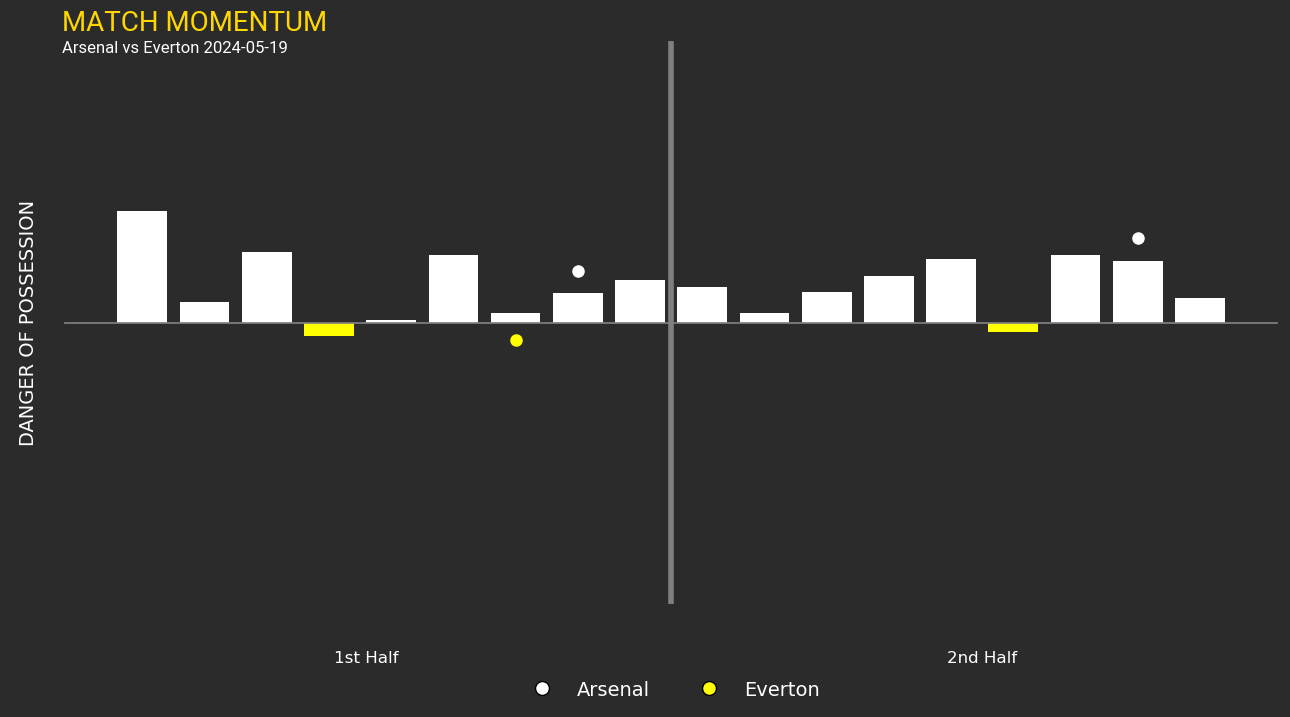

In [845]:
in_play_xT_grouped = in_play_xT.groupby(['PERIOD_ID', 'NEW_TIME_SECONDS', 'TEAM_NAME'])['xt'].sum().reset_index()

# Pivot the DataFrame to have 'NEW_TIME_SECONDS' as index and 'TEAM_NAME' as columns
pivot_df = in_play_xT_grouped.pivot(index=['NEW_TIME_SECONDS', 'PERIOD_ID'], columns='TEAM_NAME', values='xt').fillna(0)

# Calculate the difference between Arsenal and Everton for each minute
pivot_df['difference'] = pivot_df[df_match_oi['HOME_TEAM_NAME'].iloc[0]] - pivot_df[df_match_oi['AWAY_TEAM_NAME'].iloc[0]]

# Flatten the MultiIndexdddd
pivot_df.reset_index(inplace=True)

# Create bins for 'NEW_TIME_SECONDS'
bins = np.linspace(pivot_df['NEW_TIME_SECONDS'].min(), pivot_df['NEW_TIME_SECONDS'].max(), 10)  # 9 intervals = 10 bin edges
labels = [f'Bin {i+1}' for i in range(len(bins)-1)]
pivot_df['bins'] = pd.cut(pivot_df['NEW_TIME_SECONDS'], bins=bins, labels=labels, include_lowest=True)

# Aggregate the mean xT difference for each bin and period
bin_means = pivot_df.groupby(['PERIOD_ID', 'bins'])['difference'].sum().reset_index()

# Concatenate bins from both periods
bin_means['period_bin'] = bin_means['PERIOD_ID'].astype(str) + '-' + bin_means['bins'].astype(str)

# Group goals by bins
df_goals['bins'] = pd.cut(df_goals['NEW_TIME_SECONDS'], bins=bins, labels=labels, include_lowest=True)
goals_binned = df_goals.groupby(['PERIOD_ID', 'bins', 'TEAM_FBREF_ID']).size().reset_index(name='goals')

# Plotting the binned mean xT difference as a bar plot
fig, ax = plt.subplots(figsize=(14, 7))

# Change the background color
fig.patch.set_facecolor('#2B2B2B')
ax.set_facecolor('#2B2B2B')

# Remove the border around the plot
for spine in ax.spines.values():
    spine.set_edgecolor('#2B2B2B')

# Plotting bars with custom colors for positive and negative values
bars = ax.bar(bin_means['period_bin'], bin_means['difference'], color=bin_means['difference'].apply(lambda x: 'white' if x > 0 else 'yellow'))

# Set y-axis limits
y_lim = max((bin_means['difference'].abs().max())*1.25, 1.25)
ax.set_ylim([-y_lim, y_lim])

ax.grid(False)

# Add horizontal line at y=0
ax.axhline(0, color='grey', linewidth=1.25)

# Customize the title, labels, and ticks
ax.set_title('MATCH MOMENTUM', color='gold', fontsize=20, fontname='Roboto', loc='left')
fig.text(0.08, 0.86, f'{team1} vs {team2} {datetime_obj}', color='white', fontsize=12, fontname='Roboto')
# ax.set_xlabel('Bins', color='white')
ax.set_ylabel('DANGER OF POSSESSION', color='white', labelpad=-20, size=14)
ax.tick_params(colors='#2B2B2B', which='both', labelcolor='#2B2B2B')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add segregated x-axis labels for "1st Half" and "2nd Half"
halfway_point = len(bin_means['period_bin']) // 2
ax.text(halfway_point / 2.5, -1.5, '1st Half', horizontalalignment='center', color='white', fontsize=12)
ax.text(halfway_point + halfway_point / 2, -1.5, '2nd Half', horizontalalignment='center', color='white', fontsize=12)
ax.axvline(x=halfway_point - 0.5, color='gray', linestyle='-')

# Add legend with circles
colors = {team1: 'white', team2: 'yellow'}
labels = list(colors.keys())
handles = [plt.Line2D([0], [0], marker='o', color='none', markerfacecolor=colors[label], markersize=10) for label in labels]
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, facecolor='#2B2B2B', edgecolor='none', framealpha=0, fontsize=14, labelcolor='white')

# Plot goal markers
team_colors = {team1_id: 'white', team2_id: 'yellow'}
for i, row in goals_binned[goals_binned['goals'] > 0].iterrows():
    period_bin = str(row['PERIOD_ID']) + '-' + str(row['bins'])
    bar = bin_means[bin_means['period_bin'] == period_bin].index
    if len(bar) > 0:
        x_pos = bar[0]
        y_pos = bin_means.loc[x_pos, 'difference']
        for goal in range(row['goals']):
            if row['TEAM_FBREF_ID'] == team1_id:
                if y_pos > 0:
                    ax.plot(x_pos, y_pos + 0.1 + goal * 0.1, marker='o', color=team_colors[row['TEAM_FBREF_ID']], markersize=8)
                else:
                    ax.plot(x_pos, 0.075, marker='o', color=team_colors[row['TEAM_FBREF_ID']], markersize=8)
            else:
                if y_pos > 0:
                    ax.plot(x_pos, -0.075, marker='o', color=team_colors[row['TEAM_FBREF_ID']], markersize=8)
                else:
                    ax.plot(x_pos, y_pos - 0.1 - goal * 0.1, marker='o', color=team_colors[row['TEAM_FBREF_ID']], markersize=8)

plt.show()

In [846]:
df_events = df_events.sort_values(['PERIOD_ID','NEW_TIME_SECONDS', 'ORIGINAL_EVENT_ID']).reset_index(drop=True)

In [847]:
df_events.loc[df_events['PERIOD_ID'] == 2, 
              'NEW_TIME_SECONDS'] = df_events.loc[df_events['PERIOD_ID'] == 2, 'TIME_SECONDS'] + (45 * 60)

In [848]:
ws_match_oi = df_match_oi['WS_MATCH_ID'].iloc[0]

In [849]:
ws_match_oi

1729408

In [850]:
df_cards = fetch_data(cursor, f"SELECT * FROM CARDS WHERE WS_MATCH_ID = '{ws_match_oi}'")
df_subs = fetch_data(cursor, f"SELECT * FROM SUBS WHERE WS_MATCH_ID = '{ws_match_oi}'")

In [851]:
teamIds = df_events['TEAM_FBREF_ID'].unique()

In [852]:
len(df_subs_oi)

5

In [853]:
df_cards_oi[mask1]

,WS_MATCH_ID,PERIOD_ID,TIME_SECONDS,NEW_TIME_SECONDS,ORIGINAL_EVENT_ID,TEAM_WS_ID,PLAYER_WS_ID,CARD_TYPE


In [854]:
res_dict = {}
var = 'PLAYER_FBREF_NAME'
var2 = 'passRecipientName'

for teamId in teamIds:
    mask = df_events['TEAM_FBREF_ID']== teamId
    team_ws_id = team_names[team_names['TEAM_FBREF_ID'] == teamId].TEAM_WS_ID.iloc[0]
    df_cards_oi = df_cards[df_cards['TEAM_WS_ID'] == team_ws_id]
    df_subs_oi = df_subs[df_subs['TEAM_WS_ID'] == team_ws_id]
    df_ = df_events[mask]

    teamName = df_['TEAM_NAME'].unique()[0]

    mask1 = df_cards_oi['CARD_TYPE'].apply(lambda x: x in ["SecondYellow", "Red"])

    if len(mask1) > 0:
        first_red_card_time = df_cards_oi[mask1].NEW_TIME_SECONDS.min()
    else:
        first_red_card_time = np.nan

    if len(df_subs_oi) > 0:
        first_sub_time = df_subs_oi.NEW_TIME_SECONDS.min()
    else:
        first_sub_time = np.nan

    max_minute = (df_.NEW_TIME_SECONDS.max())

    all_times = [first_red_card_time, first_sub_time, max_minute]
    filtered_times = [time for time in all_times if not np.isnan(time)]

    min_time = min(filtered_times)

    df_ = df_.sort_values(['PERIOD_ID','NEW_TIME_SECONDS', 'ORIGINAL_EVENT_ID'])

    passes_df = df_.reset_index().drop('index', axis=1)
    passes_df['playerId'] = passes_df['PLAYER_WS_ID'].astype('Int64')
    passes_df = passes_df[passes_df['playerId'].notnull()]
    passes_df['passRecipientName'] = passes_df['PLAYER_FBREF_NAME'].shift(-1)
    passes_df = passes_df[passes_df['passRecipientName'].notnull()]

    mask1 = passes_df['TYPE_NAME'].apply(lambda x: x in ['pass'])
    passes_df_all = passes_df[mask1]

    mask2 = passes_df_all['NEW_TIME_SECONDS'] < min_time
    players = passes_df_all[passes_df_all['NEW_TIME_SECONDS'] < min_time]['PLAYER_FBREF_NAME'].unique()
    mask3 = passes_df_all['PLAYER_FBREF_NAME'].apply(lambda x: x in players)
    passes_df_short = passes_df_all[mask2 & mask3]

    mask2 = passes_df_all['PLAYER_FBREF_NAME'] != passes_df_all['passRecipientName']
    mask3 = passes_df_all['RESULT_ID'] == 1
    passes_df_suc = passes_df_all[mask2&mask3]

    mask2 = passes_df_suc['NEW_TIME_SECONDS'] < min_time
    players = passes_df_suc[passes_df_suc['NEW_TIME_SECONDS'] < min_time]['PLAYER_FBREF_NAME'].unique()
    mask3 = passes_df_suc['PLAYER_FBREF_NAME'].apply(lambda x: x in players) & \
            passes_df_suc['passRecipientName'].apply(lambda x: x in players)
    passes_df_suc_short = passes_df_suc[mask2 & mask3]    

    print('team: ',teamName)
    print('passes: ', passes_df_all.shape[0])
    print('suc passes: ', passes_df_suc.shape[0])
    print('suc short passes: ', passes_df_suc_short.shape[0])
    print('last minute: min(first red / substitution / end game) = ', (min_time//60) +1)
    
    print('suc passes befor last minute: ', passes_df_short.shape[0])
    print('\n')
    
    res_dict[teamId] = {}
    
    res_dict[teamId]['passes_df_all'] = passes_df_all
    res_dict[teamId]['passes_df_short'] = passes_df_short
    res_dict[teamId]['passes_df_suc'] = passes_df_suc
    res_dict[teamId]['passes_df_suc_short'] = passes_df_suc_short
    res_dict[teamId]['min_time'] = min_time

    passes_df_all = res_dict[teamId]['passes_df_all']
    passes_df_suc = res_dict[teamId]['passes_df_suc']
    passes_df_short = res_dict[teamId]['passes_df_short']
    passes_df_suc_short = res_dict[teamId]['passes_df_suc_short']
    
    player_position = passes_df_short.groupby(var).agg({'START_X': ['median'], 'START_Y': ['median']})

    player_position.columns = ['START_X', 'START_Y']
    player_position.index.name = 'PLAYER_FBREF_NAME'
    player_position.index = player_position.index.astype(str)

    player_pass_count_all = passes_df_all.groupby(var).agg({'PLAYER_WS_ID':'count'}).rename(columns={'PLAYER_WS_ID':'num_passes_all'})
    player_pass_count_suc = passes_df_suc.groupby(var).agg({'PLAYER_WS_ID':'count'}).rename(columns={'PLAYER_WS_ID':'num_passes'})
    player_pass_count_suc_short = passes_df_suc_short.groupby(var).agg({'PLAYER_WS_ID':'count'}).rename(columns={'PLAYER_WS_ID':'num_passes2'})
    player_pass_count = player_pass_count_all.join(player_pass_count_suc).join(player_pass_count_suc_short)
    
        
    passes_df_all["pair_key"] = passes_df_all.apply(lambda x: "_".join([str(x[var]), str(x[var2])]), axis=1)
    passes_df_suc["pair_key"] = passes_df_suc.apply(lambda x: "_".join([str(x[var]), str(x[var2])]), axis=1)
    passes_df_suc_short["pair_key"] = passes_df_suc_short.apply(lambda x: "_".join([str(x[var]), str(x[var2])]), axis=1)


    
    pair_pass_count_all = passes_df_all.groupby('pair_key').agg({'PLAYER_WS_ID':'count'}).rename(columns={'PLAYER_WS_ID':'num_passes_all'})
    pair_pass_count_suc = passes_df_suc.groupby('pair_key').agg({'PLAYER_WS_ID':'count'}).rename(columns={'PLAYER_WS_ID':'num_passes'})
    pair_pass_count_suc_short = passes_df_suc_short.groupby('pair_key').agg({'PLAYER_WS_ID':'count'}).rename(columns={'PLAYER_WS_ID':'num_passes2'})
    pair_pass_count = pair_pass_count_all.join(pair_pass_count_suc).join(pair_pass_count_suc_short)
    
    player_position['z'] = player_position['START_X']
    player_position['START_X'] = player_position['START_Y']
    player_position['START_Y'] = player_position['z']
    
    res_dict[teamId]['player_position'] = player_position
    res_dict[teamId]['player_pass_count'] = player_pass_count
    res_dict[teamId]['pair_pass_count'] = pair_pass_count


team:  Arsenal
passes:  644
suc passes:  571
suc short passes:  361
last minute: min(first red / substitution / end game) =  67.0
suc passes befor last minute:  404


team:  Everton
passes:  290
suc passes:  210
suc short passes:  187
last minute: min(first red / substitution / end game) =  83.0
suc passes befor last minute:  248




In [855]:
var = 'PLAYER_FBREF_NAME'
var2 = 'passRecipientName'

for teamId in teamIds:

    passes_df_all = res_dict[teamId]['passes_df_all']
    passes_df_suc = res_dict[teamId]['passes_df_suc']
    passes_df_short = res_dict[teamId]['passes_df_short']
    passes_df_suc_short = res_dict[teamId]['passes_df_suc_short']
    
    player_position = passes_df_short.groupby(var).agg({'START_X': ['median'], 'START_Y': ['median']})

    player_position.columns = ['START_X', 'START_Y']
    player_position.index.name = 'PLAYER_FBREF_NAME'
    player_position.index = player_position.index.astype(str)

    player_pass_count_all = passes_df_all.groupby(var).agg({'PLAYER_WS_ID':'count'}).rename(columns={'PLAYER_WS_ID':'num_passes_all'})
    player_pass_count_suc = passes_df_suc.groupby(var).agg({'PLAYER_WS_ID':'count'}).rename(columns={'PLAYER_WS_ID':'num_passes'})
    player_pass_count_suc_short = passes_df_suc_short.groupby(var).agg({'PLAYER_WS_ID':'count'}).rename(columns={'PLAYER_WS_ID':'num_passes2'})
    player_pass_count = player_pass_count_all.join(player_pass_count_suc).join(player_pass_count_suc_short)
    
        
    passes_df_all["pair_key"] = passes_df_all.apply(lambda x: "_".join([str(x[var]), str(x[var2])]), axis=1)
    passes_df_suc["pair_key"] = passes_df_suc.apply(lambda x: "_".join([str(x[var]), str(x[var2])]), axis=1)
    passes_df_suc_short["pair_key"] = passes_df_suc_short.apply(lambda x: "_".join([str(x[var]), str(x[var2])]), axis=1)


    
    pair_pass_count_all = passes_df_all.groupby('pair_key').agg({'PLAYER_WS_ID':'count'}).rename(columns={'PLAYER_WS_ID':'num_passes_all'})
    pair_pass_count_suc = passes_df_suc.groupby('pair_key').agg({'PLAYER_WS_ID':'count'}).rename(columns={'PLAYER_WS_ID':'num_passes'})
    pair_pass_count_suc_short = passes_df_suc_short.groupby('pair_key').agg({'PLAYER_WS_ID':'count'}).rename(columns={'PLAYER_WS_ID':'num_passes2'})
    pair_pass_count = pair_pass_count_all.join(pair_pass_count_suc).join(pair_pass_count_suc_short)
    
    
    
    # player_pass_value_suc = (passes_df_suc.groupby(var)
    #                              .agg({'xt':'sum'})
    #                              .round(3)
    #                              .rename(columns={'xt':'pass_value'}))
    # player_pass_value_suc_short = (passes_df_suc_short.groupby(var)
    #                              .agg({'xt':'sum'})
    #                              .round(3)
    #                              .rename(columns={'xt':'pass_value2'}))
    # player_pass_value = player_pass_value_suc.join(player_pass_value_suc_short)

                
    # pair_pass_value_suc = (passes_df_suc.groupby(['pair_key'])
    #                            .agg({'xt':'sum'})
    #                            .round(3)
    #                            .rename(columns={'xt':'pass_value'}))
    # pair_pass_value_suc_short = (passes_df_suc_short.groupby(['pair_key'])
    #                        .agg({'xt':'sum'})
    #                        .round(3)
    #                        .rename(columns={'xt':'pass_value2'}))
    # pair_pass_value = pair_pass_value_suc.join(pair_pass_value_suc_short)

    
    player_position['z'] = player_position['START_X']
    player_position['START_X'] = player_position['START_Y']
    player_position['START_Y'] = player_position['z']
    
    res_dict[teamId]['player_position'] = player_position
    res_dict[teamId]['player_pass_count'] = player_pass_count
    res_dict[teamId]['pair_pass_count'] = pair_pass_count
    # res_dict[teamId]['player_pass_value'] = player_pass_value
    # res_dict[teamId]['pair_pass_value'] = pair_pass_value

In [856]:
import os
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from scipy.stats import binned_statistic_2d
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import RegularPolygon, Arrow, ArrowStyle,FancyArrowPatch, Circle,FancyArrow
from mplsoccer.pitch import Pitch, VerticalPitch
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from highlight_text import fig_text, ax_text


import warnings
warnings.filterwarnings("ignore")

In [857]:
# nodes_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#E15A82',
#                                                                '#EEA934',
#                                                                '#F1CA56',
#                                                                '#DCED69',
#                                                                '#7FF7A8',
#                                                                '#5AE1AC',
#                                                                '#11C0A1'
                                                               
                                                                       
#                                                             ])
# nodes_cmap

colors = [
    (60/255, 107/255, 137/255),   # RGB(60,85,106)
    (60/255, 143/255, 136/255),  # RGB(60,112,107)
    (130/255, 201/255, 133/255), # RGB(102,151,104)
    (80/255, 226/255, 80/255)    # RGB(80,226,80)
]

cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_cmap", colors)

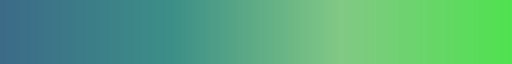

In [858]:
cmap

In [859]:
# node_cmap = cm.get_cmap(nodes_cmap)

# norm = Normalize(vmin=0, vmax=1)
# node_color1 = node_cmap(norm(0)) 
# node_color2 = node_cmap(norm(0.25)) 
# node_color3 = node_cmap(norm(0.5)) 
# node_color4 = node_cmap(norm(0.75)) 
# node_color5 = node_cmap(norm(1)) 

In [860]:
def change_range(value, old_range, new_range):

    new_value = ((value-old_range[0]) / (old_range[1]-old_range[0])) * (new_range[1]-new_range[0]) + new_range[0]
    
    if new_value >= new_range[1]:
        return new_range[1]
    elif new_value <= new_range[0]:
        return new_range[0]
    else:
        return new_value

In [861]:
#nodes
min_node_size = 12
max_node_size = 20

max_player_count = 88
min_player_count = 1

max_player_value = 10
min_player_value = 1

#font
font_size = 8
font_color = 'black'

#edges arrow

min_edge_width = 0.5
max_edge_width = 5

head_length = 0.2
head_width = 0.15

max_pair_count = 16
min_pair_count = 1

min_pair_value  = 0.01
max_pair_value = 0.085

min_passes = 5

In [862]:
player_numbers = df_player_match[['PLAYER_WS_ID', 'PLAYER_FBREF_NAME', 'TEAM_FBREF_ID', 'JERSEY_NUMBER']]

In [863]:
max_overall = 0
min_overall = 10000
for val in res_dict.keys():
    team_max = res_dict[val]['pair_pass_count']['num_passes_all'].max()
    team_min = res_dict[val]['pair_pass_count']['num_passes_all'].min()
    max_overall = max(max_overall, team_max)
    min_overall = min(min_overall, team_min)

In [864]:
teamid_selected = teamIds[0]

## Selected team's passmap

In [865]:
res_dict.keys()

dict_keys(['18bb7c10', 'd3fd31cc'])

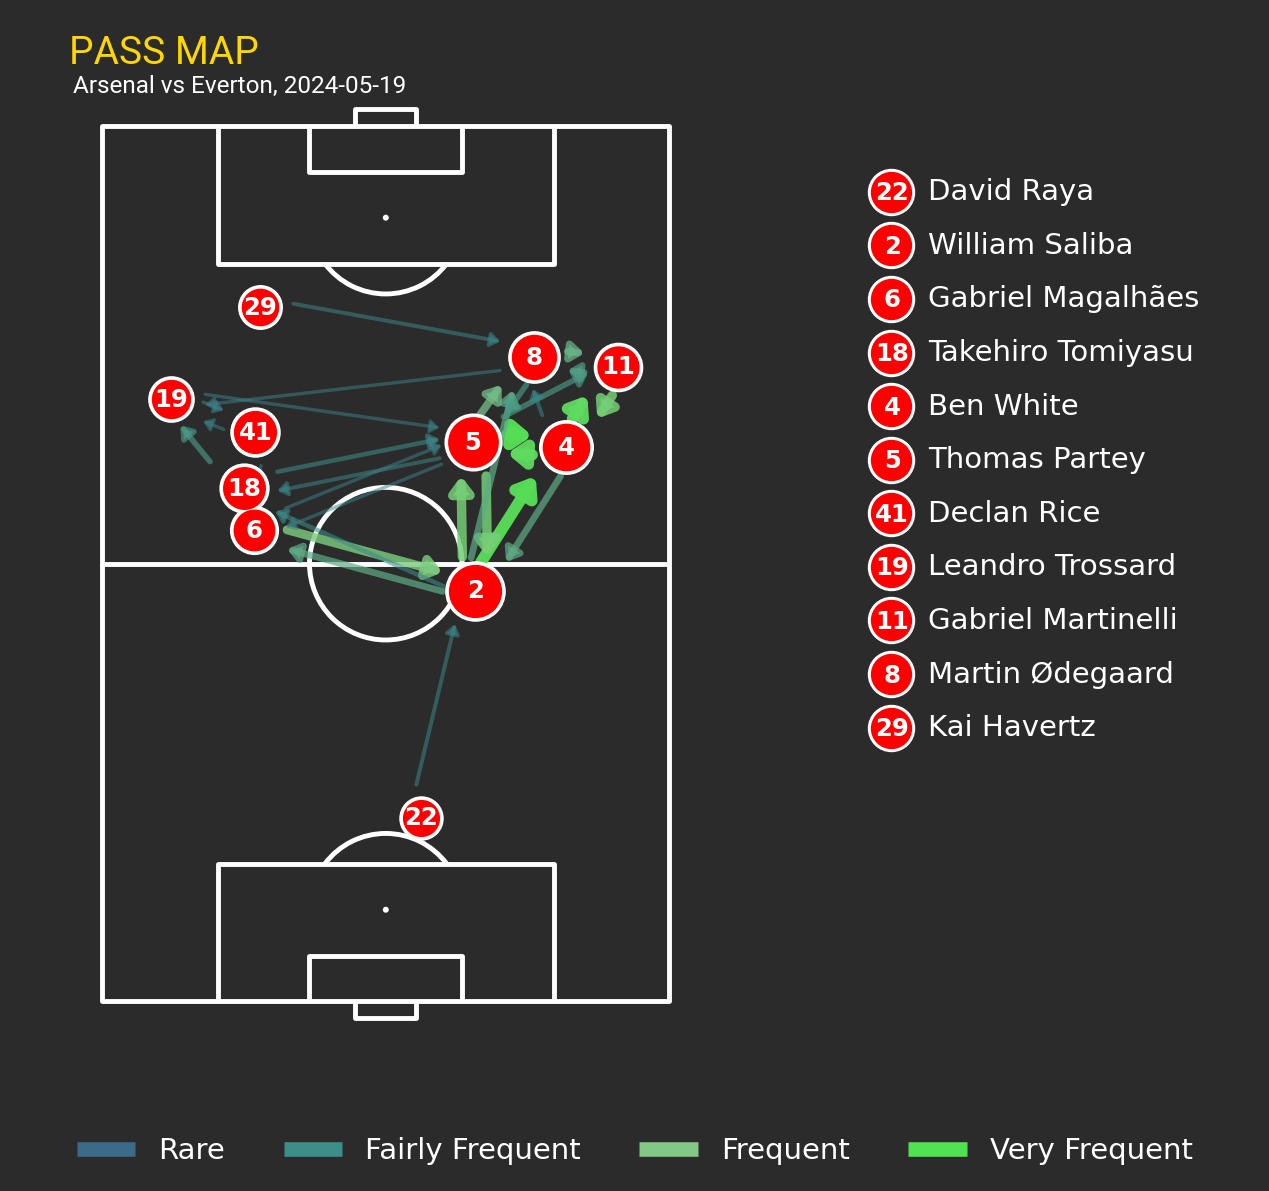

In [866]:
plt.style.use('fivethirtyeight')

fig, (ax, ax_legend) = plt.subplots(1, 2, figsize=(4, 3.5), dpi=350, gridspec_kw={'width_ratios': [2, 1]})

fig.patch.set_facecolor('#2B2B2B')

ax.set_title('PASS MAP', color='gold', fontsize=8, fontname='Roboto', loc='left')
fig.text(0.12, 0.88, f'{team1} vs {team2}, {datetime_obj}', color='white', fontsize=5, fontname='Roboto')

#define dataframes
position = res_dict[teamid_selected]['player_position']
player_pass_count = res_dict[teamid_selected]['player_pass_count']
pair_pass_count = res_dict[teamid_selected]['pair_pass_count']
minutes_ = res_dict[teamid_selected]['min_time']

pitch = VerticalPitch(pitch_type='uefa', pitch_color='#2B2B2B', line_color='white', 
                        goal_type='box', linewidth=1,
                    pad_bottom=10)

#plot vertical pitches
pitch.draw(ax=ax, constrained_layout=False, tight_layout=False)

pair_stats = pair_pass_count.sort_values('num_passes',ascending=False)
pair_stats2 = pair_stats[pair_stats['num_passes'] >= min_passes]

mask = df_events['NEW_TIME_SECONDS'] < minutes_
players_ = list(set(df_events[mask]['PLAYER_FBREF_NAME'].dropna()))

mask_ = player_pass_count.index.map(lambda x: x in players_)
player_pass_count = player_pass_count.loc[mask_]

mask_ = pair_stats2.index.map(lambda x: (x.split('_')[0] in players_) &  (x.split('_')[1] in players_))
pair_stats2 = pair_stats2[mask_]

ind = position.index.map(lambda x: x in players_)
position = position.loc[ind]

team_numbers = player_numbers[player_numbers['TEAM_FBREF_ID'] == teamid_selected]
team_numbers.set_index('PLAYER_FBREF_NAME', inplace=True)

# Step 3: plotting nodes
# print(player_pass_count)
for var, row in player_pass_count.iterrows():
    player_x = position.loc[var]["START_X"]
    player_y = position.loc[var]["START_Y"]

    num_passes = row["num_passes"]

    marker_size = change_range(num_passes, (min_player_count, max_player_count), (min_node_size, max_node_size)) 

    ax.plot(player_x, player_y, '.', color="red", markersize=marker_size, zorder=5)
    ax.plot(player_x, player_y, '.', markersize=marker_size+3, zorder=4, color='white')

    player_pass_count.loc[var, 'marker_size'] = marker_size

    # Add jersey numbers
    jersey_number = team_numbers.loc[var, 'JERSEY_NUMBER']
    ax.text(player_x, player_y, str(jersey_number), color='white', ha='center', va='center', fontsize=5, fontweight='bold', zorder=6)


# Step 4: ploting edges  
for pair_key, row in pair_stats2.iterrows():
    player1, player2 = pair_key.split("_")

    player1_x = position.loc[player1]["START_X"]
    player1_y = position.loc[player1]["START_Y"]

    player2_x = position.loc[player2]["START_X"]
    player2_y = position.loc[player2]["START_Y"]

    num_passes = row["num_passes"]
    # pass_value = row["pass_value"]

    line_width = 2.5
    alpha = change_range(num_passes, (min_overall, max_overall), (0.4, 1))

    norm_color = Normalize(vmin=min_overall, vmax=max_overall)
    norm_size = change_range(num_passes, (min_overall, max_overall), (0.1, 1))
    # print(norm(num_passes))
    # edge_cmap = cm.get_cmap(nodes_cmap)
    # edge_color = "#00FF00"

    x = player1_x
    y = player1_y
    dx = player2_x-player1_x
    dy = player2_y-player1_y
    rel = 80/105
    shift_x = 1.5
    shift_y = shift_x*rel

    slope = round(abs((player2_y - player1_y)*105/100 / (player2_x - player1_x)*68/100),1)

    color_ = cmap(norm_color(num_passes)) 
    # print(color_) 

    mutation_scale = 1
    if (slope > 0.5):
        if dy > 0:
            ax.annotate("", xy=(x+dx+shift_x, y+dy), xytext=(x+shift_x, y),zorder=2,
                    arrowprops=dict(arrowstyle=f'-|>, head_length = {head_length*alpha}, \
                                    head_width={head_width*alpha}',
                                    alpha = alpha,
                                    color=color_,
                                    # fc = 'blue',
                                    lw=line_width * norm_size,
                                    shrinkA=7,
                                    shrinkB=7))
            
            
        elif dy <= 0:
            ax.annotate("", xy=(x+dx-shift_x, y+dy), xytext=(x-shift_x, y),zorder=2,
                    arrowprops=dict(arrowstyle=f'-|>, head_length = {head_length*alpha}, \
                                    head_width={head_width*alpha}',
                                    alpha = alpha,
                                    color=color_,
                                    # fc = 'blue',
                                    lw=line_width * norm_size,
                                    shrinkA=7,
                                    shrinkB=7))
            
    elif (slope <= 0.5) & (slope >=0):
        if dx > 0:
#                 print(2)

            ax.annotate( "", xy=(x+dx, y+dy-shift_y), xytext=(x, y-shift_y),zorder=2,
                    arrowprops=dict(arrowstyle=f'-|>, head_length = {head_length*alpha}, \
                                    head_width={head_width*alpha}',
                                    alpha = alpha,
                                    color=color_,
                                    # fc = 'blue',
                                    lw=line_width * norm_size,
                                    shrinkA=7,
                                    shrinkB=7))

        elif dx <= 0:

            ax.annotate("", xy=(x+dx, y+dy+shift_y), xytext=(x, y+shift_y),zorder=2,
                    arrowprops=dict(arrowstyle=f'-|>, head_length = {head_length*alpha}, \
                                    head_width={head_width*alpha}',
                                    alpha = alpha,
                                    color=color_,
                                    # fc = 'blue',
                                    lw=line_width * norm_size,
                                    shrinkA=7,
                                    shrinkB=7))

    else:
        print(1)

# Add the legend
ax_legend.set_facecolor('#2B2B2B')
ax_legend.axis('off')
for idx, player in enumerate(list(position.sort_values(by='START_Y', ascending=True).index)):
    jersey_number = team_numbers.loc[player, 'JERSEY_NUMBER']
    ax_legend.plot(0.07, 0.9 - idx * 0.054, '.', color="red", markersize=15, zorder=5, transform=ax_legend.transAxes)
    ax_legend.plot(0.07, 0.9 - idx * 0.054, '.', markersize=17.5, zorder=4, color='white', transform=ax_legend.transAxes)
    ax_legend.text(0.072, 0.892 - idx * 0.054, str(jersey_number), color='white', fontsize=5, zorder=6,
                   fontweight='bold', ha='center', transform=ax_legend.transAxes)
    ax_legend.text(0.17, 0.892 - idx * 0.054, player, color='white', fontsize=6, ha='left', transform=ax_legend.transAxes)

# Add the legend for pass frequency
legend_elements = [
    mpl.lines.Line2D([0], [0], color=(60/255, 107/255, 137/255), lw=3, label='Rare'),
    mpl.lines.Line2D([0], [0], color=(60/255, 143/255, 136/255), lw=3, label='Fairly Frequent'),
    mpl.lines.Line2D([0], [0], color=(130/255, 201/255, 133/255), lw=3, label='Frequent'),
    mpl.lines.Line2D([0], [0], color=(80/255, 226/255, 80/255), lw=3, label='Very Frequent')
]

fig.legend(handles=legend_elements, loc='lower center', ncol=4, facecolor='#2B2B2B', edgecolor='none', 
           framealpha=0, fontsize=6, labelcolor='white')

plt.show()

In [867]:
position.sort_values(by='START_Y', ascending=True).index

Index(['David Raya', 'William Saliba', 'Gabriel Magalhães',
       'Takehiro Tomiyasu', 'Ben White', 'Thomas Partey', 'Declan Rice',
       'Leandro Trossard', 'Gabriel Martinelli', 'Martin Ødegaard',
       'Kai Havertz'],
      dtype='object', name='PLAYER_FBREF_NAME')

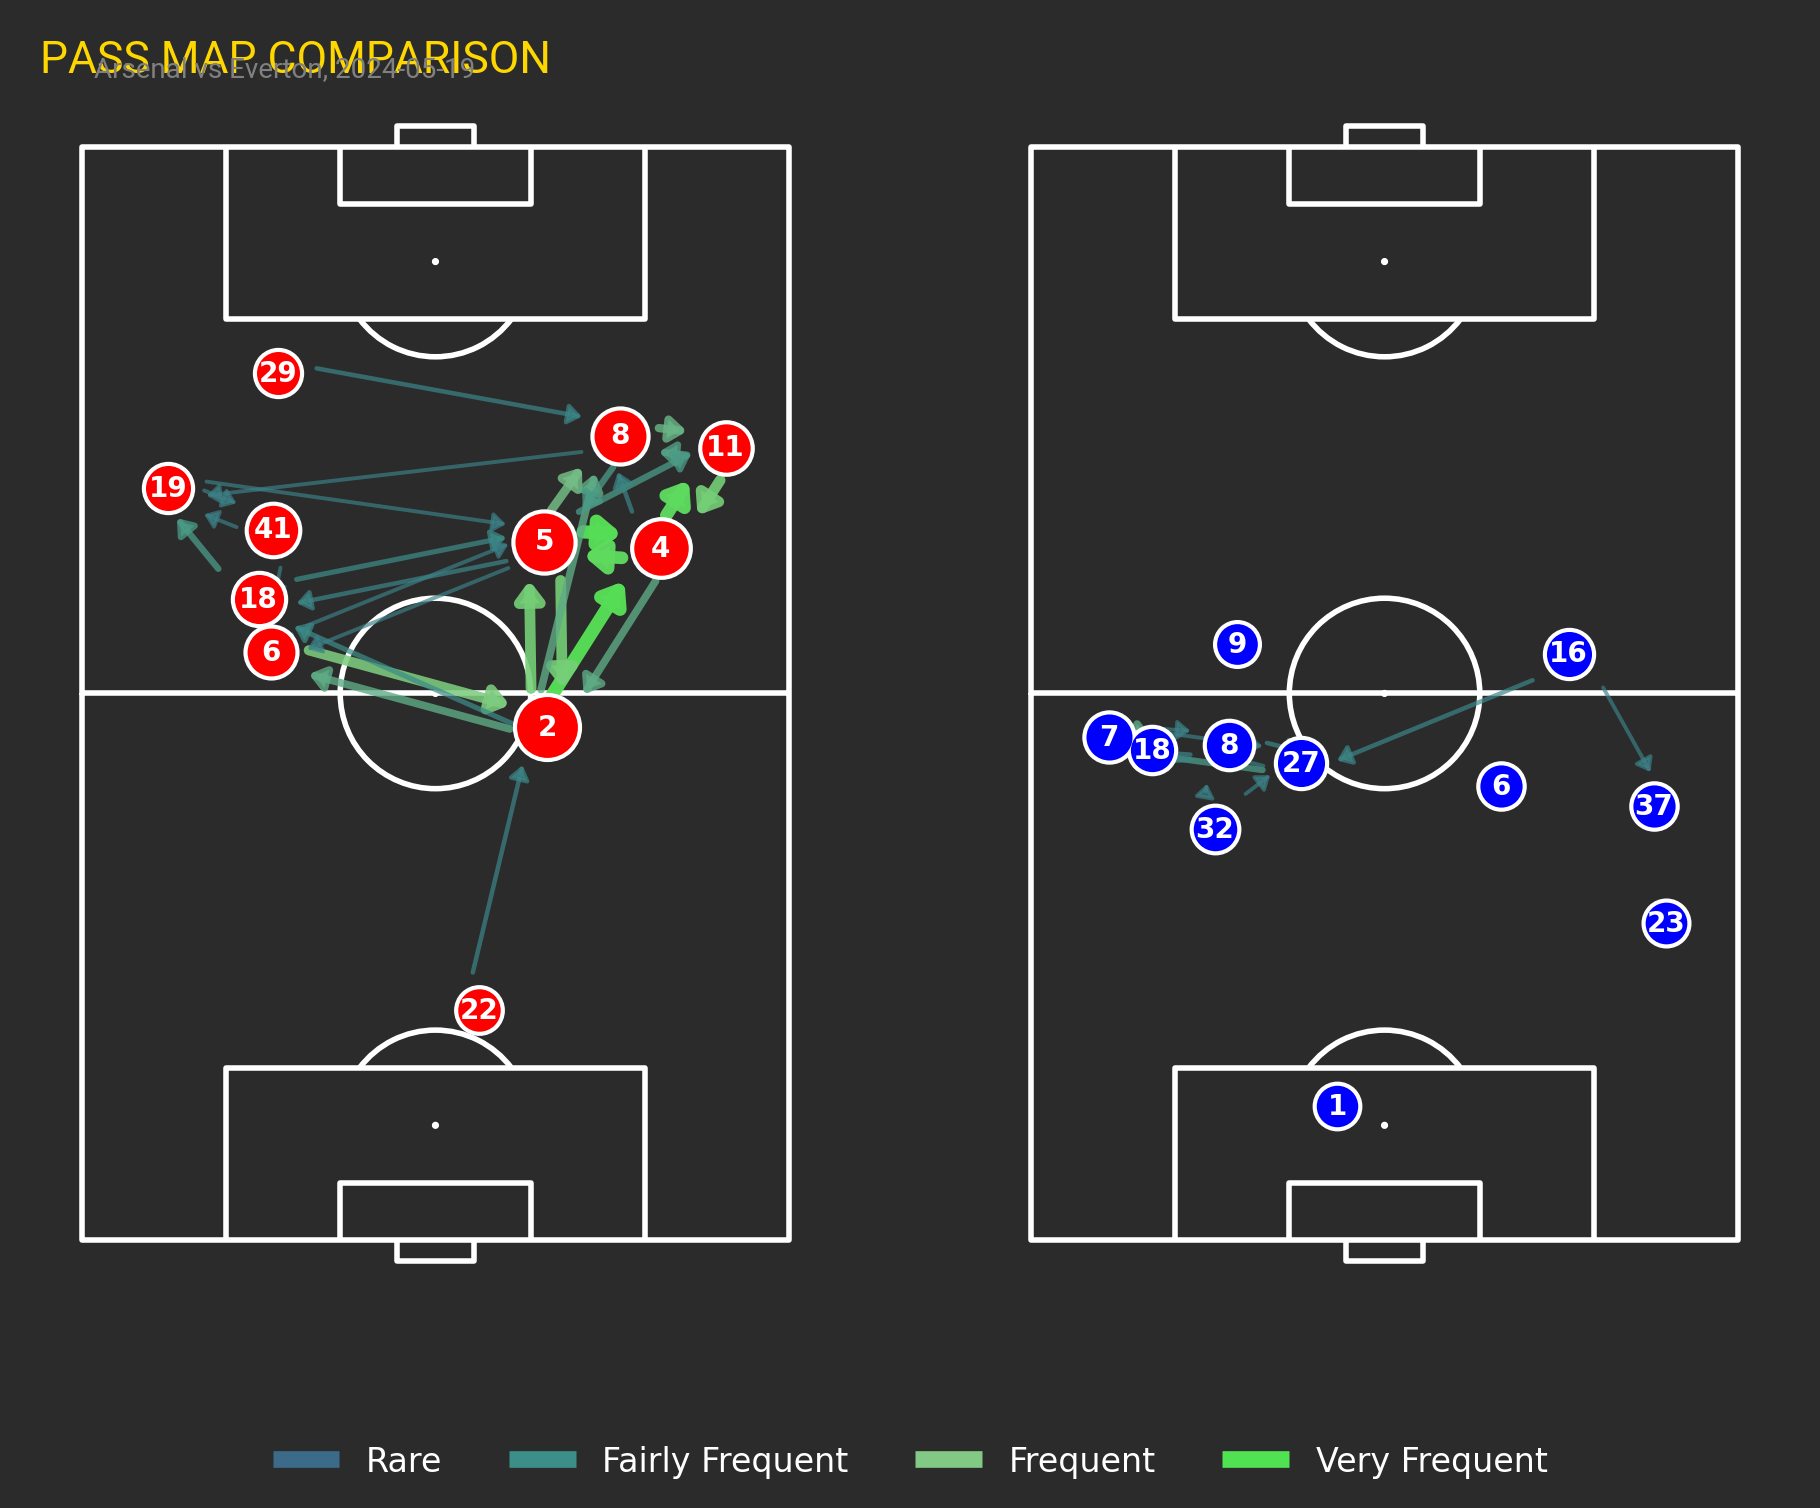

In [868]:
plt.style.use('fivethirtyeight')

fig,ax = plt.subplots(1,2,figsize=(5,4), dpi=400)

fig.patch.set_facecolor('#2B2B2B')

teamId_home = teamIds[0]
teamId_away = teamIds[1]
team_colors = ["red", "blue"]

ax[0].set_title('PASS MAP COMPARISON', color='gold', fontsize=8, fontname='Roboto', loc='left')
fig.text(0.107, 0.88, f'{team1} vs {team2}, {datetime_obj}', color='grey', fontsize=5, fontname='Roboto')

for i, teamid in enumerate([teamId_home, teamId_away]):    

    #define dataframes
    position = res_dict[teamid]['player_position']
    player_pass_count = res_dict[teamid]['player_pass_count']
    pair_pass_count = res_dict[teamid]['pair_pass_count']
    minutes_ = res_dict[teamid]['min_time']

    pitch = VerticalPitch(pitch_type='uefa', pitch_color='#2B2B2B', line_color='white', 
                          goal_type='box', linewidth=1,
                        pad_bottom=10)
    
    #plot vertical pitches
    pitch.draw(ax=ax[i], constrained_layout=False, tight_layout=False)
    
    pair_stats = pair_pass_count.sort_values('num_passes',ascending=False)
    pair_stats2 = pair_stats[pair_stats['num_passes'] >= min_passes]

    mask = df_events['NEW_TIME_SECONDS'] < minutes_
    players_ = list(set(df_events[mask]['PLAYER_FBREF_NAME'].dropna()))

    mask_ = player_pass_count.index.map(lambda x: x in players_)
    player_pass_count = player_pass_count.loc[mask_]

    mask_ = pair_stats2.index.map(lambda x: (x.split('_')[0] in players_) &  (x.split('_')[1] in players_))
    pair_stats2 = pair_stats2[mask_]
    
    ind = position.index.map(lambda x: x in players_)
    position = position.loc[ind]

    team_numbers = player_numbers[player_numbers['TEAM_FBREF_ID'] == teamid]
    team_numbers.set_index('PLAYER_FBREF_NAME', inplace=True)
    
    # Step 3: plotting nodes
    # print(player_pass_count)
    for var, row in player_pass_count.iterrows():
        player_x = position.loc[var]["START_X"]
        player_y = position.loc[var]["START_Y"]

        num_passes = row["num_passes"]

        marker_size = change_range(num_passes, (min_player_count, max_player_count), (min_node_size, max_node_size)) 

        ax[i].plot(player_x, player_y, '.', color=team_colors[i], markersize=marker_size, zorder=5)
        ax[i].plot(player_x, player_y, '.', markersize=marker_size+3, zorder=4, color='white')

        player_pass_count.loc[var, 'marker_size'] = marker_size

        # Add jersey numbers
        jersey_number = team_numbers.loc[var, 'JERSEY_NUMBER']
        ax[i].text(player_x, player_y, str(jersey_number), color='white', ha='center', va='center', fontsize=5, fontweight='bold', zorder=6)


    # Step 4: ploting edges  
    for pair_key, row in pair_stats2.iterrows():
        player1, player2 = pair_key.split("_")

        player1_x = position.loc[player1]["START_X"]
        player1_y = position.loc[player1]["START_Y"]

        player2_x = position.loc[player2]["START_X"]
        player2_y = position.loc[player2]["START_Y"]

        num_passes = row["num_passes"]
        # pass_value = row["pass_value"]

        line_width = 2.5
        alpha = change_range(num_passes, (min_overall, max_overall), (0.6, 1))

        norm_color = Normalize(vmin=min_overall, vmax=max_overall)
        norm_size = change_range(num_passes, (min_overall, max_overall), (0.1, 1))
        # print(norm(num_passes))
        # edge_cmap = cm.get_cmap(nodes_cmap)
        # edge_color = "#00FF00"

        x = player1_x
        y = player1_y
        dx = player2_x-player1_x
        dy = player2_y-player1_y
        rel = 80/105
        shift_x = 1.5
        shift_y = shift_x*rel

        slope = round(abs((player2_y - player1_y)*105/100 / (player2_x - player1_x)*68/100),1)

        color_ = cmap(norm_color(num_passes)) 
        # print(color_) 

        mutation_scale = 1
        if (slope > 0.5):
            if dy > 0:
                ax[i].annotate("", xy=(x+dx+shift_x, y+dy), xytext=(x+shift_x, y),zorder=2,
                        arrowprops=dict(arrowstyle=f'-|>, head_length = {head_length*alpha}, \
                                        head_width={head_width*alpha}',
                                        alpha = alpha,
                                        color=color_,
                                        # fc = 'blue',
                                        lw=line_width * norm_size,
                                        shrinkA=7,
                                        shrinkB=7))
                
                
            elif dy <= 0:
                ax[i].annotate("", xy=(x+dx-shift_x, y+dy), xytext=(x-shift_x, y),zorder=2,
                        arrowprops=dict(arrowstyle=f'-|>, head_length = {head_length*alpha}, \
                                        head_width={head_width*alpha}',
                                        alpha = alpha,
                                        color=color_,
                                        # fc = 'blue',
                                        lw=line_width * norm_size,
                                        shrinkA=7,
                                        shrinkB=7))
                
        elif (slope <= 0.5) & (slope >=0):
            if dx > 0:
#                 print(2)

                ax[i].annotate( "", xy=(x+dx, y+dy-shift_y), xytext=(x, y-shift_y),zorder=2,
                        arrowprops=dict(arrowstyle=f'-|>, head_length = {head_length*alpha}, \
                                        head_width={head_width*alpha}',
                                        alpha = alpha,
                                        color=color_,
                                        # fc = 'blue',
                                        lw=line_width * norm_size,
                                        shrinkA=7,
                                        shrinkB=7))

            elif dx <= 0:

                ax[i].annotate("", xy=(x+dx, y+dy+shift_y), xytext=(x, y+shift_y),zorder=2,
                        arrowprops=dict(arrowstyle=f'-|>, head_length = {head_length*alpha}, \
                                        head_width={head_width*alpha}',
                                        alpha = alpha,
                                        color=color_,
                                        # fc = 'blue',
                                        lw=line_width * norm_size,
                                        shrinkA=7,
                                        shrinkB=7))
        else:
            print(1)

fig.legend(handles=legend_elements, loc='lower center', ncol=4, facecolor='#2B2B2B', edgecolor='none', 
           framealpha=0, fontsize=6, labelcolor='white')

In [871]:
df_shots_fbref = fetch_data(cursor, f"SELECT * FROM SHOT_EVENTS WHERE MATCH_ID = '{match_oi}'")

In [872]:
df_shots_ws = df_events[df_events['TYPE_NAME'].str.contains('shot', case=False, na=False)]

In [873]:
df_goals_fbref = df_shots_fbref[df_shots_fbref['OUTCOME'] == "Goal"]
df_goals_fbref.shape

(3, 12)

In [874]:
df_shots = df_shots_ws.merge(df_shots_fbref[['MATCH_ID', 'ACTION_ID', 'XG', 'OUTCOME']], 
                             on=['MATCH_ID', 'ACTION_ID'], how='left')

In [875]:
df_events[df_events['ACTION_ID'] == 721]

,MATCH_ID,ORIGINAL_EVENT_ID,PERIOD_ID,TIME_SECONDS,NEW_TIME_SECONDS,TEAM_FBREF_ID,PLAYER_WS_ID,START_X,END_X,START_Y,END_Y,RESULT_ID,ACTION_ID,TYPE_NAME,BODYPART_NAME,PLAYER_FBREF_NAME,TEAM_NAME
721,3e33bd98,2.689678e+09,1,2798.0,2798.0,d3fd31cc,110189,32.865,70.035,35.156,9.384,1,721,freekick_crossed,foot,Jordan Pickford,Everton


In [876]:
df_shots["Minutes"] = df_shots['NEW_TIME_SECONDS'] // 60

In [885]:
df_events['NEW_TIME_SECONDS'].max()//60

104.0

In [884]:
df_events

,MATCH_ID,ORIGINAL_EVENT_ID,PERIOD_ID,TIME_SECONDS,NEW_TIME_SECONDS,TEAM_FBREF_ID,PLAYER_WS_ID,START_X,END_X,START_Y,END_Y,RESULT_ID,ACTION_ID,TYPE_NAME,BODYPART_NAME,PLAYER_FBREF_NAME,TEAM_NAME
0,3e33bd98,2.689622e+09,1,0.0,0.0,18bb7c10,332325,52.500,30.450,34.000,32.436,1,0,pass,foot,Declan Rice,Arsenal
1,3e33bd98,2.689622e+09,1,3.0,3.0,18bb7c10,276366,31.395,37.170,29.784,19.788,1,1,pass,foot,David Raya,Arsenal
2,3e33bd98,2.689622e+09,1,6.0,6.0,18bb7c10,322036,37.275,34.545,19.788,26.044,1,2,pass,foot,Ben White,Arsenal
3,3e33bd98,2.689622e+09,1,8.0,8.0,18bb7c10,361822,34.335,40.425,26.520,34.952,1,3,pass,foot,William Saliba,Arsenal
4,3e33bd98,NaN,1,10.0,10.0,18bb7c10,377283,40.425,49.245,34.952,43.384,1,4,dribble,foot,Takehiro Tomiyasu,Arsenal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685,3e33bd98,NaN,2,3530.5,6230.5,d3fd31cc,131464,28.980,33.390,10.200,6.800,1,1685,dribble,foot,James Tarkowski,Everton
1686,3e33bd98,2.689735e+09,2,3532.0,6232.0,d3fd31cc,131464,33.390,35.175,6.800,9.656,0,1686,pass,foot,James Tarkowski,Everton
1687,3e33bd98,2.689735e+09,2,3533.0,6233.0,18bb7c10,273257,65.520,69.090,59.092,54.536,1,1687,dribble,foot,Oleksandr Zinchenko,Arsenal
1688,3e33bd98,2.689735e+09,2,3535.0,6235.0,18bb7c10,273257,69.090,74.445,54.536,11.764,1,1688,pass,foot,Oleksandr Zinchenko,Arsenal


In [880]:
team_shots

,MATCH_ID,ORIGINAL_EVENT_ID,PERIOD_ID,TIME_SECONDS,NEW_TIME_SECONDS,TEAM_FBREF_ID,PLAYER_WS_ID,START_X,END_X,START_Y,END_Y,RESULT_ID,ACTION_ID,TYPE_NAME,BODYPART_NAME,PLAYER_FBREF_NAME,TEAM_NAME,XG,OUTCOME,Minutes,cumulative_xG
6,3e33bd98,2.689646e+09,1,1012.0,1012.0,d3fd31cc,141469,80.430,89.565,27.132,28.832,0,328,shot_freekick,foot_right,Dominic Calvert-Lewin,Everton,0.06,Blocked,16.0,0.06
8,3e33bd98,2.689663e+09,1,1866.0,1866.0,d3fd31cc,141469,89.040,105.000,41.004,37.740,0,543,shot,foot_right,Dominic Calvert-Lewin,Everton,0.34,Off Target,31.0,0.40
9,3e33bd98,2.689663e+09,1,1867.0,1867.0,d3fd31cc,141469,94.710,105.000,41.344,38.624,0,544,shot,foot_right,Dominic Calvert-Lewin,Everton,0.12,Woodwork,31.0,0.52
12,3e33bd98,2.689670e+09,1,2351.0,2351.0,d3fd31cc,80464,79.275,105.000,42.296,32.232,1,648,shot_freekick,foot_right,Idrissa Gana Gueye,Everton,0.06,Goal,39.0,0.58
17,3e33bd98,2.689707e+09,2,1535.0,4235.0,d3fd31cc,141469,87.570,104.055,44.064,34.612,0,1139,shot,foot_right,Dominic Calvert-Lewin,Everton,0.07,Saved,70.0,0.65


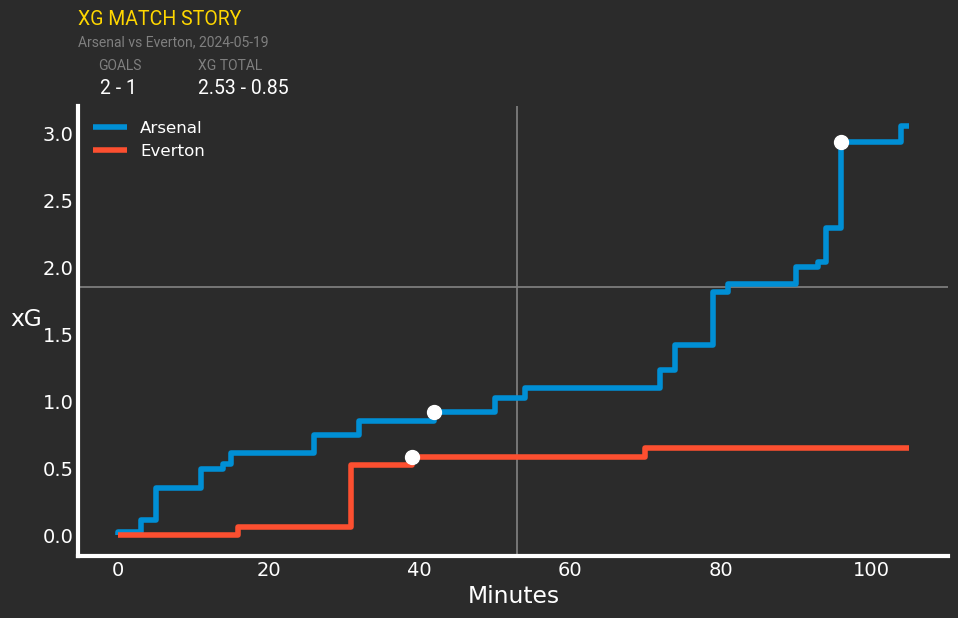

In [886]:
df_shots['cumulative_xG'] = df_shots.groupby('TEAM_NAME')['XG'].cumsum()

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.grid(False)

# Get unique teams
teams = df_shots['TEAM_NAME'].unique()

max_mins = (df_events['NEW_TIME_SECONDS'].max()//60)+1

# Plot xG for each team
for team in teams:
    team_shots = df_shots[df_shots['TEAM_NAME'] == team]
    new_row_top = {
    "MATCH_ID": None, "ORIGINAL_EVENT_ID": None, "PERIOD_ID": None, "TIME_SECONDS": None, "NEW_TIME_SECONDS": None,
    "TEAM_FBREF_ID": None, "PLAYER_WS_ID": None, "START_X": None, "END_X": None, "START_Y": None, "END_Y": None,
    "RESULT_ID": None, "ACTION_ID": None, "TYPE_NAME": None, "BODYPART_NAME": None, "PLAYER_FBREF_NAME": None, "TEAM_NAME": None,
    "XG": None, "OUTCOME": None, "Minutes": 0.0, "cumulative_xG": 0.0
    }
    new_row_bottom = {
    "MATCH_ID": None, "ORIGINAL_EVENT_ID": None, "PERIOD_ID": None, "TIME_SECONDS": None, "NEW_TIME_SECONDS": None,
    "TEAM_FBREF_ID": None, "PLAYER_WS_ID": None, "START_X": None, "END_X": None, "START_Y": None, "END_Y": None,
    "RESULT_ID": None, "ACTION_ID": None, "TYPE_NAME": None, "BODYPART_NAME": None, "PLAYER_FBREF_NAME": None, "TEAM_NAME": None,
    "XG": None, "OUTCOME": None, "Minutes": float(max_mins), "cumulative_xG": team_shots["cumulative_xG"].max()
    }
    team_shots = pd.concat([pd.DataFrame([new_row_top]), team_shots, pd.DataFrame([new_row_bottom])], ignore_index=True)

    ax.step(team_shots['Minutes'], team_shots['cumulative_xG'], where='post', label=team)

# Add goals (assuming goals are the max xG at each shot for simplification)
for i, row in df_shots.iterrows():
    if row['OUTCOME'] == 'Goal':
        ax.plot(row['Minutes'], row['cumulative_xG'], 'o', color='white', markersize=10)

xg_vline = (df_events[df_events['PERIOD_ID'] == 1]['NEW_TIME_SECONDS'].max() // 60) + 1
ax.axvline(xg_vline, color='grey', linewidth=1.25, zorder= 0)

ax.axhline(df_shots['XG'].sum()/2, color='grey', linewidth=1.25, zorder= 0)

# Customize plot
ax.set_facecolor('#2B2B2B')
fig.patch.set_facecolor('#2B2B2B')
plt.subplots_adjust(top=0.82)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
fig.suptitle('XG MATCH STORY', color='gold', fontsize=14, fontname='Roboto', x=0.08,ha='left')
fig.text(0.08, 0.92, f'{team1} vs {team2}, {datetime_obj}', color='grey', fontsize=10, fontname='Roboto')
# ax.set_title('PASS MAP', color='gold', fontsize=14, fontname='Roboto', loc='left')

goals_team1 = 2
goals_team2 = 1
xg_team1 = 2.53
xg_team2 = 0.85
# Add total goals and xG stats
fig.text(0.1, 0.88, 'GOALS', ha='left', color='grey', fontsize=10, fontname='Roboto', fontweight='bold')
fig.text(0.102, 0.84, f'{goals_team1} - {goals_team2}', ha='left', color='white', fontsize=14, fontweight='bold', fontname='Roboto')

fig.text(0.2, 0.88, 'XG TOTAL', ha='left', color='grey', fontsize=10, fontname='Roboto', fontweight='bold')
fig.text(0.2, 0.84, f'{xg_team1} - {xg_team2}', ha='left', color='white', fontsize=14, fontweight='bold', fontname='Roboto')


ax.set_xlabel('Minutes')
ax.set_ylabel('xG', rotation=0, labelpad=12)
ax.legend(loc='upper left', facecolor='#2B2B2B', edgecolor='none', framealpha=0, fontsize=12, labelcolor='white')

# Display plot
plt.show()
